In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal



import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from common import EEG_fif
from common import create_dataloader

In [3]:
torch.cuda.is_available()

True

In [4]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = ''
base_url = 'https://physionet.org/files/eegmmidb/'
#runs = [4, 6, 8, 10, 12,14]
#runs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
#runs = [3,4,5,6,7,8,9,10,11,12,13,14]

#runs = [11,13,15,17]
#runs = [4,6,8,10]
#runs = [3,5,7,9,4,6,8,10]



#runs = [3]
subjects = [62]

print(path)
eeg = EEG_fif(path, base_url, subjects, runs)
raw=eeg.data_to_raw()

print("Raw done")
# apply filter
#freq = (1., 45.)

#raw=eeg.raw_ica(n_components=8,max_iter=1000)
raw=raw.notch_filter([50,75,100])
raw=raw.filter( 8,14, method='fir', verbose=20)


print("Filter done")



Raw done
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filter done


/home/nutapolt/eeg_mi/common.py:627: RuntimeWarning: This filename (S001/S001R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/eeg_mi/common.py:627: RuntimeWarning: This filename (S001/S001R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s re

In [5]:
raw.ch_names

['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'STIM MARKERS']

In [6]:
#raw = raw.drop_channels(['C3'])
raw = raw.drop_channels(['Fp1', 'Fp2', 'P7', 'P8', 'O1', 'O2'])
raw.ch_names

['C3', 'C4', 'STIM MARKERS']

In [7]:
#epochs=eeg.epochs_visu(raw,tmin=0,tmax=6,baseline=(0,3))
epochs=eeg.epochs_visu(raw,tmin=0,tmax=7,baseline=(0,2))

60 events found
Event IDs: [1 2 4]
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 1751 original time points ...
1 bad epochs dropped


/home/nutapolt/eeg_mi/common.py:657: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(


In [8]:
#X = X[:, :,np.newaxis,:]
X, y = eeg.get_X_y(epochs)
print(X.shape)
X=X[:,:,int(0.25*250):int(1750-(250*1))]
#X = X[:, np.newaxis,:,:]
print(X.shape)
y=y-1
y


(19, 2, 1751)
(19, 2, 1438)


array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y)

print('train size',X_train.shape, y_train.shape)
print('Test size',X_test.shape, y_test.shape)

train size (13, 2, 1438) (13,)
Test size (6, 2, 1438) (6,)


In [10]:

batch_size = X_train.shape[2]

train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

num_step =math.ceil(len(train_loader.dataset) / batch_size)

in_channels  = X.shape[1]  #C3, C4
out_channels = 64  #five is logical because we have freq= 8, 9, 10, 11, 12 that we want to capture
out_size     = 2  #left or right
kernel_size  = 5


In [11]:
X_train = torch.FloatTensor(X_train)
fake_eeg_data = torch.randn_like(X_train) #(batch_size, channel, length)

In [12]:
        
        #using sequential helps bind multiple operations together
layer1 = nn.Sequential(
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
layer2 = nn.Sequential(
            nn.Conv1d(out_channels, out_channels*2, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm1d(out_channels*2),
            nn.ReLU()
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
layer3 = nn.Sequential(
            nn.Conv1d(out_channels*2, out_channels, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
        

In [13]:
out = layer1(fake_eeg_data)
out.shape

torch.Size([13, 64, 1438])

In [14]:
out = layer2(out)
out.shape

torch.Size([13, 128, 1438])

In [15]:
out = layer3(out)
out.shape

torch.Size([13, 64, 1438])

In [16]:
out = out.reshape(out.size(0), -1)

linear_shape = out.shape[1]
linear_shape

92032

In [17]:
fc = nn.Linear(linear_shape, out_size)
out = fc(out)
out.shape

torch.Size([13, 2])

In [18]:


# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, out_size):
        super().__init__()
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(out_channels, out_channels*2, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm1d(out_channels*2),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv1d(out_channels*2, out_channels, kernel_size=kernel_size, stride=1, padding=2),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )
        
        
        self.fc = nn.Linear(linear_shape  , out_size)
        #self.fc = nn.Linear(80064 , 2)
        
        self.drop_out = nn.Dropout(0.5)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        out = self.layer3(out)
        #out = self.drop_out(out)
        #out = self.layer4(out)
        #out = self.drop_out(out)

        out = out.reshape(out.size(0), -1)   #can also use .view()
        out = self.fc(out)
        return out

### Freeze layer

In [26]:
del net
net = ConvNet(in_channels, out_channels, kernel_size, out_size).cuda(0)

In [27]:
net.load_state_dict(torch.load('New/0.6563_OurData_CNN_2class_S49_5S_EX_0.6563_73.9130'))

<All keys matched successfully>

In [28]:
parms = net.state_dict()
parms.keys()

odict_keys(['layer1.0.weight', 'layer1.0.bias', 'layer1.1.weight', 'layer1.1.bias', 'layer1.1.running_mean', 'layer1.1.running_var', 'layer1.1.num_batches_tracked', 'layer2.0.weight', 'layer2.0.bias', 'layer2.1.weight', 'layer2.1.bias', 'layer2.1.running_mean', 'layer2.1.running_var', 'layer2.1.num_batches_tracked', 'layer3.0.weight', 'layer3.0.bias', 'layer3.1.weight', 'layer3.1.bias', 'layer3.1.running_mean', 'layer3.1.running_var', 'layer3.1.num_batches_tracked', 'fc.weight', 'fc.bias'])

In [29]:
for name,param in net.named_parameters():
    if param.requires_grad and 'layer1' in name:
        param.requires_grad = False
    if param.requires_grad and 'layer2' in name:
        param.requires_grad = False
    # if param.requires_grad and 'layer3' in name:
    #     param.requires_grad = False

In [30]:
import wandb
wandb.login()


wand = wandb.init(
        
      # Set the project where this run will be logged
      project="Motor-Imagery", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"OurData_CNN_3layer_cuttime_2class_S49_findtune_freeze_1_2_online_EX", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.00000001,
      "architecture": "CNN",
      "dataset": "S20",
      "epochs": 1000000,
      "weightname":"OurData_CNN_3layer_cuttime_2class_S49_findtune_freeze_1_2_online_EX",
      "num_step_per_epoch" : num_step, 
        
      }
    )




config = wand.config
print(config.num_step_per_epoch)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Test/Test_accuracy,████▅▅▅▅▅▅▅▅▅▅▅▅▅▅███████▅▅▅▁▁▁▁▁▁▁▁▁▁▁▁
Test/Test_loss,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇██
train/train_accuracy,▄▁▅▃█▂▅▅▆▆▅▇▇▇▇▇▅████▇██▇███████████████
train/train_loss,██▇▇▅▇▅▆▅▅▅▅▄▄▄▄▄▃▃▃▃▄▃▃▂▂▃▂▂▂▁▂▁▁▁▁▂▁▁▁
Test/Test_accuracy,66.66667
Test/Test_loss,0.63308
train/train_accuracy,100.0
train/train_loss,0.12855


1


In [31]:
from common import train
#net = ConvNet().cuda(0)
optimizer = optim.Adam(net.parameters(), lr=config.learning_rate)
criterion = nn.CrossEntropyLoss()


train_loss,valid_loss,train_accuracy,valid_accuracy =train(
    model = net,
    gpu_num = 0,
    train_loader = train_loader,
    test_loader = test_loader,
    optimizer = optimizer  ,
    criterion = criterion ,
    vail_loader = None,
    wand = wand
         )


wandb.alert(
            title='Finish',
            text=f'Finishing training',
        )

Epoch 1/1000000, Tr Loss: 0.7645, Tr Acc: 38.4615, Val Loss: 0.6006, Val Acc: 83.3333
Epoch 101/1000000, Tr Loss: 0.7709, Tr Acc: 53.8462, Val Loss: 0.6023, Val Acc: 100.0000
Epoch 201/1000000, Tr Loss: 0.8395, Tr Acc: 23.0769, Val Loss: 0.6028, Val Acc: 100.0000
Epoch 301/1000000, Tr Loss: 0.6433, Tr Acc: 69.2308, Val Loss: 0.6027, Val Acc: 100.0000
Epoch 401/1000000, Tr Loss: 0.7797, Tr Acc: 38.4615, Val Loss: 0.6029, Val Acc: 100.0000
Epoch 501/1000000, Tr Loss: 0.6633, Tr Acc: 53.8462, Val Loss: 0.6029, Val Acc: 100.0000
Epoch 601/1000000, Tr Loss: 0.6014, Tr Acc: 61.5385, Val Loss: 0.6032, Val Acc: 100.0000
Epoch 701/1000000, Tr Loss: 0.7622, Tr Acc: 38.4615, Val Loss: 0.6033, Val Acc: 100.0000
Epoch 801/1000000, Tr Loss: 0.6612, Tr Acc: 53.8462, Val Loss: 0.6033, Val Acc: 100.0000
Epoch 901/1000000, Tr Loss: 0.6044, Tr Acc: 76.9231, Val Loss: 0.6034, Val Acc: 100.0000
Epoch 1001/1000000, Tr Loss: 0.7418, Tr Acc: 53.8462, Val Loss: 0.6033, Val Acc: 100.0000
Epoch 1101/1000000, Tr 

KeyboardInterrupt: 

### Validate Findtune

In [52]:
del net

In [53]:
net = ConvNet(in_channels, out_channels, kernel_size, out_size).cuda(0)

In [68]:
net.load_state_dict(torch.load('OurData_CNN_3layer_cuttime_2class_S49_findtune_freeze_1_2_online_ex_find_MI_C3_C4/0.5584_OurData_CNN_3layer_cuttime_2class_S49_findtune_freeze_1_2_online_ex_find_MI_C3_C4_0.5584_83.3333'))

<All keys matched successfully>

In [70]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = ''
base_url = 'https://physionet.org/files/eegmmidb/'
#runs = [4, 6, 8, 10, 12,14]
#runs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
#runs = [3,4,5,6,7,8,9,10,11,12,13,14]
runs = [4]
#runs = [11,13,15,17]
#runs = [4,6,8,10]
#runs = [3,5,7,9,4,6,8,10]
subjects = [1]

print(path)
eeg = EEG_fif(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
print(raw)
print("Raw done")
# apply filter
#freq = (1., 45.)

#raw=eeg.raw_ica(n_components=8,max_iter=1000)
raw=raw.notch_filter([50,75,100])
raw=raw.filter( 8,14, method='fir', verbose=20)


print("Filter done")



<Raw | S001R04.fif, 9 x 36305 (145.2 s), ~2.5 MB, data loaded>
Raw done
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 413 samples (

/home/nutapolt/eeg_mi/common.py:627: RuntimeWarning: This filename (S001/S001R04.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/eeg_mi/common.py:627: RuntimeWarning: This filename (S001/S001R04.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s re

In [71]:
raw.ch_names
raw = raw.drop_channels(['Fp1', 'Fp2', 'P7', 'P8', 'O1', 'O2'])
raw.ch_names

['C3', 'C4', 'STIM MARKERS']

In [72]:
#epochs=eeg.epochs_visu(raw,tmin=0,tmax=6,baseline=(0,3))
epochs=eeg.epochs_visu(raw,tmin=0,tmax=7,baseline=(0,2))

60 events found
Event IDs: [1 2 4]
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 20 events and 1751 original time points ...
1 bad epochs dropped


/home/nutapolt/eeg_mi/common.py:657: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(


In [73]:
#X = X[:, :,np.newaxis,:]
X, y = eeg.get_X_y(epochs)
print(X.shape)

#X=X[:,:,int(0.25*250):1500]
X=X[:,:,int(0.25*250):int(1750-(250*1))]
#X = X[:, np.newaxis,:,:]
print(X.shape)
y=y-1
y

(19, 2, 1751)
(19, 2, 1438)


array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [74]:

batch_size = 1438





In [75]:
test_loader = create_dataloader(X, y, batch_size=batch_size)
num_step =math.ceil(len(test_loader.dataset) / batch_size)

In [76]:
# Train the model
num_epochs = 1

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
old_acc = 0
for epoch in range(num_epochs):

    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(0)
            classes = classes.cuda(0)
        
        outputs = net(items)
        #loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        
        for i in range(predicted.shape[0]):
            
            if predicted[i] == classes.data[i]:
                correct += 1
            
        #correct += (predicted == classes.data).sum()
        
        iterations += 1

    #valid_loss.append(loss/iterations)
    #correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct / len(test_loader.dataset) * 100.0)
print (' Val Acc: %.4f'
                   %(valid_accuracy[-1]))


 Val Acc: 52.6316


In [77]:
predicted


tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1],
       device='cuda:0')

In [78]:
y_true=classes.data.cpu().numpy()
y_true

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0])

In [79]:
predicted

tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1],
       device='cuda:0')

In [80]:
y_pred=predicted.cpu().numpy()
y_pred

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1])

In [81]:
confusion_matrix(y_true, y_pred)

array([[5, 5],
       [4, 5]])

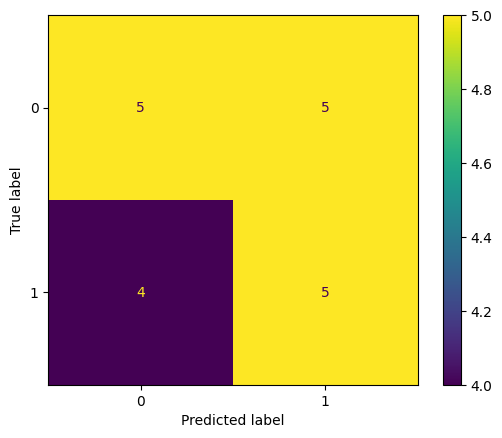

In [82]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

### Validate Findtune V2

In [ ]:
del net

In [ ]:
net = ConvNet().cuda(0)

In [ ]:
torch.cuda.get_device_name(0)

In [ ]:
net.load_state_dict(torch.load('OurData_CNN_4layer_2ch_2class_S20_EX_10_Nov_findtune/0.5425_OurData_CNN_3layer_cuttime_2class_S20_EX_findtune_freeze_1_2_online_MI_C3_C4_0.5425_88.8889'))

In [ ]:
# Train the model
num_epochs = 1

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
old_acc = 0
for epoch in range(num_epochs):

    loss = 0.0
    correct = 0
    iterations = 0
    net.eval()
    for i, (items, classes) in enumerate(test_loader):
        items = Variable(items)
        classes = Variable(classes)
        
        if cuda.is_available():
            items = items.cuda(1)
            classes = classes.cuda(1)
        
        outputs = net(items)
        loss += criterion(outputs, classes).item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    valid_loss.append(loss/iterations)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) * 100.0)
print (' Val Acc: %.4f'
                   %(valid_accuracy[-1]))


In [ ]:
y

In [ ]:
y_pred=predicted.cpu().numpy()


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
confusion_matrix(y, y_pred)

In [ ]:
ConfusionMatrixDisplay.from_predictions(y, y_pred)